# Stock Prediction Using Tweets

### This first section is some overall analysis of stock market in general
# Jump To Microsoft Section

In [2]:
import time
from tweepy.streaming import StreamListener
from tweepy import OAuthHandler
from tweepy import Stream
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import base64
%matplotlib inline

C_KEY = '2Ag2prupW0wf5absJiRRD4tvQ'
C_SECRET = 'GQQzRUyTWLlVNRUeNC4DsTTIT533SrrfddlkocieE7YZKBYXFs'
A_TOKEN_KEY = '2279494118-w2vsoB6op8QeT0715de4uRBUNq5pA5DCiFZaG2Z'
A_TOKEN_SECRET = 'EkVbbpWx0X6n5idWnEUpzkweoBweftl7xKUzEz3KaerPd'


In [2]:
class Stock:
    '''
    Class designed to handle metadata associated with each Stock type
    Includes Symbol, name, sector, industry, and summary link
    '''
    def __init__(self,symbol_in,name_in,sector_in,industry_in, link_in):
        ''' Initialize all the values'''
        self.symbol = symbol_in
        self.name = name_in
        self.sector = sector_in
        self.industry = industry_in
        self.link = link_in
    def __str__(self):
        ''' Overload print function for viewing stock'''
        out = str(self.symbol) + "\n" + str(self.name) + "\n" + str(self.sector) + "\n" + str(self.industry)
        return out

#### Preprocess  NASDAQ StockList and store it in custom class 
Only keep top 33% in terms of Market Cap

In [72]:
nasdaq = pd.read_csv('companylist.csv',keep_default_na=False)
nasdaq.head()

,Symbol,Name,LastSale,MarketCap,IPOyear,Sector,industry,Summary Quote,Unnamed: 8
0,YI,"111, Inc.",8.34,$680.08M,2018,Health Care,Medical/Nursing Services,https://www.nasdaq.com/symbol/yi,
1,PIH,"1347 Property Insurance Holdings, Inc.",5.88,$35.24M,2014,Finance,Property-Casualty Insurers,https://www.nasdaq.com/symbol/pih,
2,PIHPP,"1347 Property Insurance Holdings, Inc.",24.2,n/a,n/a,Finance,Property-Casualty Insurers,https://www.nasdaq.com/symbol/pihpp,
3,TURN,180 Degree Capital Corp.,1.9068,$59.34M,n/a,Finance,Finance/Investors Services,https://www.nasdaq.com/symbol/turn,
4,FLWS,"1-800 FLOWERS.COM, Inc.",18.29,$1.17B,1999,Consumer Services,Other Specialty Stores,https://www.nasdaq.com/symbol/flws,


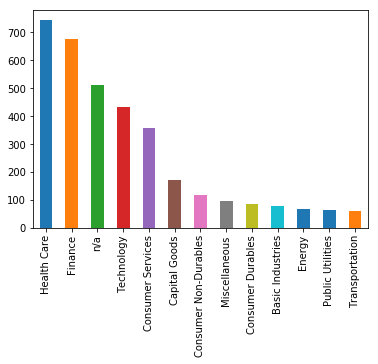

In [73]:
fig, ax = plt.subplots()
nasdaq['Sector'].value_counts().plot(ax=ax, kind='bar')

In [74]:
nasdaq["MarketCap"].head()

0    $680.08M
1     $35.24M
2         n/a
3     $59.34M
4      $1.17B
Name: MarketCap, dtype: object

*Convert MarketCap into Integer*

In [75]:
def MarketCapConvert(old_format):
    '''
    Converts a monetary value format into float
    Ex: $1.17B --> 1170000000
    '''
    M_cap = str(old_format)
    if M_cap == "n/a":
        return 0
    else:
        Million=True
        if 'B' in M_cap:
            Million=False
        M_cap = M_cap.replace('$','')
        M_cap = M_cap.replace('M','')
        M_cap = M_cap.replace('B','')
        M_cap = float(M_cap)
        if Million:
            M_cap *= 1000000
        else:
            M_cap *= 1000000000
        return M_cap

nasdaq['MarketCap'] = nasdaq['MarketCap'].apply(MarketCapConvert)
nasdaq["MarketCap"].head()

0    6.800800e+08
1    3.524000e+07
2    0.000000e+00
3    5.934000e+07
4    1.170000e+09
Name: MarketCap, dtype: float64

In [78]:
nasdaq = nasdaq.sort_values(by='MarketCap', ascending=False)
nasdaq.head(30)

,Symbol,Name,LastSale,MarketCap,IPOyear,Sector,industry,Summary Quote,Unnamed: 8
2083,MSFT,Microsoft Corporation,112.53,8.633500e+11,1986,Technology,Computer Software: Prepackaged Software,https://www.nasdaq.com/symbol/msft,
211,AAPL,Apple Inc.,174.97,8.250300e+11,1980,Technology,Computer Manufacturing,https://www.nasdaq.com/symbol/aapl,
152,AMZN,"Amazon.com, Inc.",1671.73,8.211600e+11,1997,Consumer Services,Catalog/Specialty Distribution,https://www.nasdaq.com/symbol/amzn,
136,GOOGL,Alphabet Inc.,1148.52,7.984400e+11,n/a,Technology,"Computer Software: Programming, Data Processing",https://www.nasdaq.com/symbol/googl,
135,GOOG,Alphabet Inc.,1140.99,7.932000e+11,2004,Technology,"Computer Software: Programming, Data Processing",https://www.nasdaq.com/symbol/goog,
3082,TTNP,"Titan Pharmaceuticals, Inc.",1.85,6.678389e+11,n/a,Health Care,Biotechnology: Biological Products (No Diagnos...,https://www.nasdaq.com/symbol/ttnp,
1062,FB,"Facebook, Inc.",162.28,4.631500e+11,2012,Technology,"Computer Software: Programming, Data Processing",https://www.nasdaq.com/symbol/fb,
1631,INTC,Intel Corporation,53.3,2.396900e+11,n/a,Technology,Semiconductors,https://www.nasdaq.com/symbol/intc,
664,CSCO,"Cisco Systems, Inc.",51.41,2.263100e+11,1990,Technology,Computer Communications Equipment,https://www.nasdaq.com/symbol/csco,
721,CMCSA,Comcast Corporation,39.1,1.769700e+11,n/a,Consumer Services,Television Services,https://www.nasdaq.com/symbol/cmcsa,


# Microsoft Analysis
- Focus on predicting whether a given day's stock price will go up or down using the previous 10 days of tweets and the previous 10 days of stock prices
- If this is succesful, this can be scaled to train other models and also to predict percentage change as well

In [3]:
STOCK_TO_ANALYZE = "Microsoft"
msft_stock = pd.read_csv('MSFT.csv')
msft_stock.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-04-27,47.230000,48.130001,47.220001,48.029999,43.880901,59248200
1,2015-04-28,47.779999,49.209999,47.700001,49.160000,44.913280,60730800
2,2015-04-29,48.720001,49.310001,48.500000,49.060001,44.821926,47804600
3,2015-04-30,48.700001,49.540001,48.599998,48.639999,44.438210,64725500
4,2015-05-01,48.580002,48.880001,48.400002,48.660000,44.456478,38937300


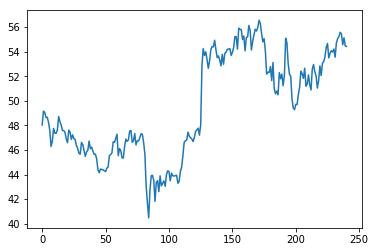

In [5]:
plot = msft_stock['Close'].plot()
fig = plot.get_figure()
fig.savefig("msft_close.png")

##### Import Data from 1TB Twitter Dump on MSU Arctic Server

In [89]:
import sys
!{sys.executable} -m pip install paramiko

    100% |████████████████████████████████| 194kB 630kB/s ta 0:00:01
    100% |████████████████████████████████| 61kB 1.8MB/s ta 0:00:011
    100% |████████████████████████████████| 286kB 633kB/s ta 0:00:01


In [5]:
import pymongo

class Tweet:
    '''
    Class designed to handle a Tweet storing 
    [text, date, follower count, and location]
    Tweets with keyword will be stored in a MongoDB collection 
    '''
    def __init__(self, date_in, text_in, followers_count_in, location_in, key_stock):
        ''' Initialize all the values'''
        self.date = date_in
        self.text = text_in.lower()
        self.followers_count = followers_count_in
        self.location = location_in
        self.keyword = key_stock
    def process_date(self,date):
        ''' Use regex to parse date and store based on accepted format'''
        pass
    def send_to_db(self):
        ''' Send tweets with keywords to MongoDB, ignore rest'''
        if self.keyword.lower() not in self.text:
            return False
        else:
            try:
                record = {'date': self.date, 'text': self.text, 'followers': self.followers_count, 'location': self.location}
                connection = pymongo.MongoClient()
                db = connection['tweet_dump']
                db[self.keyword].insert_one(record)
                connection.close()
                return True
            except:
                return False

        
        pass
    def __str__(self):
        ''' Overload print function for viewing stock'''
        out = str(self.date) + "\n" + str(self.text) + "\n" + str(self.followers_count) + "\n" + str(self.location)
        return out

### Approach 1 - Iterate through every tweet and store tweets with keyword in local MongoDB database

In [178]:
import paramiko
from pass_keys import *
import json

#Establish connection with the arctic.cse.msu.edu
ssh = paramiko.SSHClient()
ssh.set_missing_host_key_policy(paramiko.AutoAddPolicy())
ssh.connect('arctic.cse.msu.edu', username=arctic_username, password=arctic_password,key_filename='/Users/ritwikbiswas/.ssh/id_rsa')
data_path = '/user/research/ptan/data/Twitter/'
stdin, stdout, stderr = ssh.exec_command('cd ' + data_path + '; ls;')



In [179]:
#Iterate through files
count = 0
tweets_added= 0
total_tweets=0
for line in stdout:
    if count == 5:
        pass
    file_name = data_path + line.strip('\n')
    
    #open file
    sftp_client = ssh.open_sftp()
    remote_file = sftp_client.open(file_name)
    file_line_count = 0
    tweets_in_file = 0
    try:
        for line in remote_file:
            if total_tweets % 1000 == 0:
                print(str(total_tweets) + " analyzed.")
            try:
                json_tweet = json.loads(line) 
                current_tweet = Tweet(json_tweet['created_at'],json_tweet['text'],
                                   json_tweet['user']['followers_count'],json_tweet['user']['location'], 
                                   key_stock = STOCK_TO_ANALYZE)
                success = current_tweet.send_to_db()
                if success:
                    #Print every 100 total tweets
                    tweets_added += 1
                    if tweets_added % 100 == 0:
                        print(str(tweets_added) + " positive recorded\n")
                        
                    # Limit to 100 tweets per file
                    tweets_in_file += 1
                    if tweets_in_file >=100:
                        break
                    
            except:
                continue
            file_line_count += 1
            total_tweets += 1
    finally:
        
        remote_file.close()
    count += 1
    print("File " + str(count) + " finished")
ssh.close()

0 analyzed.
1000 analyzed.
File 1 finished
2000 analyzed.
3000 analyzed.
File 2 finished
File 3 finished
4000 analyzed.
5000 analyzed.
File 4 finished
File 5 finished
6000 analyzed.
7000 analyzed.
8000 analyzed.
File 6 finished
File 7 finished
9000 analyzed.
10000 analyzed.
11000 analyzed.
12000 analyzed.
13000 analyzed.
14000 analyzed.
15000 analyzed.
16000 analyzed.
17000 analyzed.
18000 analyzed.
19000 analyzed.
20000 analyzed.
21000 analyzed.
22000 analyzed.
23000 analyzed.
24000 analyzed.
25000 analyzed.
26000 analyzed.
27000 analyzed.
28000 analyzed.
29000 analyzed.
File 8 finished
30000 analyzed.
31000 analyzed.
32000 analyzed.
33000 analyzed.
34000 analyzed.
35000 analyzed.
36000 analyzed.
37000 analyzed.
38000 analyzed.
39000 analyzed.
40000 analyzed.
41000 analyzed.
42000 analyzed.
43000 analyzed.
44000 analyzed.
45000 analyzed.
46000 analyzed.
47000 analyzed.
48000 analyzed.
49000 analyzed.
50000 analyzed.
51000 analyzed.
52000 analyzed.
53000 analyzed.
54000 analyzed.
55000

440000 analyzed.
441000 analyzed.
File 50 finished
442000 analyzed.
443000 analyzed.
File 51 finished
File 52 finished
444000 analyzed.
File 53 finished
File 54 finished
445000 analyzed.
File 55 finished
446000 analyzed.
File 56 finished
File 57 finished
447000 analyzed.
448000 analyzed.
449000 analyzed.
450000 analyzed.
451000 analyzed.
452000 analyzed.
453000 analyzed.
454000 analyzed.
455000 analyzed.
456000 analyzed.
457000 analyzed.
458000 analyzed.
459000 analyzed.
460000 analyzed.
461000 analyzed.
462000 analyzed.
463000 analyzed.
464000 analyzed.
File 58 finished
465000 analyzed.
File 59 finished
466000 analyzed.
467000 analyzed.
468000 analyzed.
469000 analyzed.
470000 analyzed.
471000 analyzed.
472000 analyzed.
473000 analyzed.
474000 analyzed.
475000 analyzed.
476000 analyzed.
477000 analyzed.
478000 analyzed.
479000 analyzed.
480000 analyzed.
481000 analyzed.
482000 analyzed.
483000 analyzed.
484000 analyzed.
485000 analyzed.
486000 analyzed.
487000 analyzed.
488000 analyze

871000 analyzed.
872000 analyzed.
873000 analyzed.
874000 analyzed.
875000 analyzed.
876000 analyzed.
File 90 finished
File 91 finished
877000 analyzed.
878000 analyzed.
879000 analyzed.
880000 analyzed.
881000 analyzed.
882000 analyzed.
883000 analyzed.
884000 analyzed.
885000 analyzed.
886000 analyzed.
887000 analyzed.
888000 analyzed.
889000 analyzed.
889000 analyzed.
890000 analyzed.
891000 analyzed.
892000 analyzed.
893000 analyzed.
894000 analyzed.
895000 analyzed.
File 92 finished
File 93 finished
896000 analyzed.
897000 analyzed.
898000 analyzed.
899000 analyzed.
900000 analyzed.
901000 analyzed.
902000 analyzed.
903000 analyzed.
904000 analyzed.
905000 analyzed.
906000 analyzed.
907000 analyzed.
908000 analyzed.
909000 analyzed.
910000 analyzed.
911000 analyzed.
File 94 finished
File 95 finished
912000 analyzed.
913000 analyzed.
914000 analyzed.
915000 analyzed.
916000 analyzed.
917000 analyzed.
918000 analyzed.
919000 analyzed.
919000 analyzed.
920000 analyzed.
921000 analyze

1270000 analyzed.
1271000 analyzed.
1272000 analyzed.
1273000 analyzed.
1274000 analyzed.
1275000 analyzed.
File 133 finished
1276000 analyzed.
1277000 analyzed.
1278000 analyzed.
1279000 analyzed.
1280000 analyzed.
File 134 finished
File 135 finished
1281000 analyzed.
File 136 finished
File 137 finished
1282000 analyzed.
File 138 finished
1283000 analyzed.
1284000 analyzed.
1285000 analyzed.
1286000 analyzed.
File 139 finished
1287000 analyzed.
File 140 finished
1288000 analyzed.
1289000 analyzed.
1290000 analyzed.
1291000 analyzed.
1292000 analyzed.
1293000 analyzed.
File 141 finished
1294000 analyzed.
1295000 analyzed.
File 142 finished
1296000 analyzed.
File 143 finished
1297000 analyzed.
1298000 analyzed.
1299000 analyzed.
1300000 analyzed.
1301000 analyzed.
1302000 analyzed.
1303000 analyzed.
1304000 analyzed.
1305000 analyzed.
1306000 analyzed.
1307000 analyzed.
1308000 analyzed.
1309000 analyzed.
1310000 analyzed.
1311000 analyzed.
File 144 finished
1312000 analyzed.
1313000 an

1669000 analyzed.
1670000 analyzed.
1671000 analyzed.
1672000 analyzed.
1673000 analyzed.
1674000 analyzed.
1675000 analyzed.
1676000 analyzed.
1677000 analyzed.
File 188 finished
File 189 finished
File 190 finished
1678000 analyzed.
1679000 analyzed.
1680000 analyzed.
File 191 finished
1681000 analyzed.
1682000 analyzed.
1683000 analyzed.
1684000 analyzed.
1685000 analyzed.
1686000 analyzed.
1687000 analyzed.
1688000 analyzed.
1689000 analyzed.
1690000 analyzed.
1691000 analyzed.
1692000 analyzed.
1693000 analyzed.
1694000 analyzed.
1695000 analyzed.
File 192 finished
1696000 analyzed.
1697000 analyzed.
1698000 analyzed.
1699000 analyzed.
1700000 analyzed.
1701000 analyzed.
1702000 analyzed.
1703000 analyzed.
1704000 analyzed.
1705000 analyzed.
1706000 analyzed.
1707000 analyzed.
1708000 analyzed.
1709000 analyzed.
1710000 analyzed.
1711000 analyzed.
1712000 analyzed.
1713000 analyzed.
1714000 analyzed.
File 193 finished
1715000 analyzed.
1716000 analyzed.
1717000 analyzed.
1718000 an

2098000 analyzed.
2099000 analyzed.
2100000 analyzed.
2101000 analyzed.
2102000 analyzed.
2103000 analyzed.
2104000 analyzed.
2105000 analyzed.
2106000 analyzed.
2107000 analyzed.
2108000 analyzed.
2109000 analyzed.
2110000 analyzed.
2111000 analyzed.
2112000 analyzed.
2113000 analyzed.
2114000 analyzed.
2115000 analyzed.
2116000 analyzed.
2117000 analyzed.
2118000 analyzed.
2119000 analyzed.
2120000 analyzed.
2121000 analyzed.
2122000 analyzed.
2123000 analyzed.
2124000 analyzed.
2125000 analyzed.
2126000 analyzed.
2127000 analyzed.
2128000 analyzed.
2129000 analyzed.
2130000 analyzed.
2131000 analyzed.
2132000 analyzed.
2133000 analyzed.
2134000 analyzed.
2135000 analyzed.
2136000 analyzed.
2137000 analyzed.
2138000 analyzed.
2139000 analyzed.
2140000 analyzed.
2141000 analyzed.
2142000 analyzed.
2143000 analyzed.
2144000 analyzed.
2145000 analyzed.
2146000 analyzed.
2147000 analyzed.
2148000 analyzed.
2149000 analyzed.
2150000 analyzed.
2151000 analyzed.
2152000 analyzed.
2153000 an

2541000 analyzed.
2542000 analyzed.
2543000 analyzed.
2544000 analyzed.
2545000 analyzed.
2546000 analyzed.
2547000 analyzed.
2548000 analyzed.
2549000 analyzed.
2550000 analyzed.
File 222 finished
2551000 analyzed.
2552000 analyzed.
2553000 analyzed.
2554000 analyzed.
2555000 analyzed.
2556000 analyzed.
2557000 analyzed.
2558000 analyzed.
2559000 analyzed.
2560000 analyzed.
2561000 analyzed.
2562000 analyzed.
2563000 analyzed.
2564000 analyzed.
2565000 analyzed.
2566000 analyzed.
2567000 analyzed.
2568000 analyzed.
2569000 analyzed.
2570000 analyzed.
2571000 analyzed.
2572000 analyzed.
2573000 analyzed.
2574000 analyzed.
2575000 analyzed.
2576000 analyzed.
2577000 analyzed.
2578000 analyzed.
2579000 analyzed.
2580000 analyzed.
2581000 analyzed.
2582000 analyzed.
2583000 analyzed.
2584000 analyzed.
2585000 analyzed.
2586000 analyzed.
2587000 analyzed.
2588000 analyzed.
2589000 analyzed.
2590000 analyzed.
2591000 analyzed.
2592000 analyzed.
2593000 analyzed.
2594000 analyzed.
2595000 an

2967000 analyzed.
2968000 analyzed.
2969000 analyzed.
2970000 analyzed.
2971000 analyzed.
2972000 analyzed.
2973000 analyzed.
2974000 analyzed.
2975000 analyzed.
2976000 analyzed.
2977000 analyzed.
2977000 analyzed.
2978000 analyzed.
2979000 analyzed.
2980000 analyzed.
2981000 analyzed.
2982000 analyzed.
2983000 analyzed.
2984000 analyzed.
2985000 analyzed.
2986000 analyzed.
2987000 analyzed.
2988000 analyzed.
File 242 finished
2989000 analyzed.
2990000 analyzed.
2991000 analyzed.
2992000 analyzed.
2993000 analyzed.
2994000 analyzed.
2995000 analyzed.
2996000 analyzed.
2997000 analyzed.
2998000 analyzed.
2999000 analyzed.
3000000 analyzed.
3001000 analyzed.
3002000 analyzed.
3003000 analyzed.
3004000 analyzed.
3005000 analyzed.
3006000 analyzed.
3007000 analyzed.
3008000 analyzed.
3009000 analyzed.
3010000 analyzed.
3011000 analyzed.
3012000 analyzed.
3013000 analyzed.
3014000 analyzed.
3015000 analyzed.
3016000 analyzed.
3017000 analyzed.
File 243 finished
3018000 analyzed.
3019000 an

KeyboardInterrupt: 

Tried approach #1, analyzed 3.2 million tweets and returned 373 Microsoft tweets. This approach was not scalable and would have taken > 1.5 years to finish iterating through the billions of tweets

### Approach 2 - Iteratively grep for key stock through all the files and store instances of tweets in local MongoDB

In [216]:
#Establish connection with the arctic.cse.msu.edu
ssh = paramiko.SSHClient()
ssh.set_missing_host_key_policy(paramiko.AutoAddPolicy())
ssh.connect('arctic.cse.msu.edu', username=arctic_username, password=arctic_password,key_filename='/Users/ritwikbiswas/.ssh/id_rsa')
data_path = '/user/research/ptan/data/Twitter/'
stdin, stdout, stderr = ssh.exec_command('cd ' + data_path + '; ls;')

In [217]:
#Iterate through files
count = 0
tweets_added= 0
total_tweets=0
for line in stdout:
    if count == 10:
        pass
    file_name = data_path + line.strip('\n')
    
    #search file
    stdin, stdout, stderr = ssh.exec_command('grep ' + STOCK_TO_ANALYZE.lower() + ' ' + str(file_name))
    if count % 100==0:
        print(file_name)
        print("File number " + str(count) + " \n")
    for tweet in stdout:
        try:
            json_tweet = json.loads(tweet) 
#             print(json_tweet)
            current_tweet = Tweet(json_tweet['created_at'],json_tweet['text'],
                               json_tweet['user']['followers_count'],json_tweet['user']['location'], 
                               key_stock = STOCK_TO_ANALYZE)
            success = current_tweet.send_to_db()
#             print(current_tweet)
            if success:
                #Print every 100 total tweets
                tweets_added += 1
                if tweets_added % 100 == 0:
                    print(str(tweets_added) + " positive recorded\n")

#                 # Limit to 100 tweets per file
#                 tweets_in_file += 1
#                 if tweets_in_file >=100:
#                     break

        except:
            continue
    sftp_client = ssh.open_sftp()
    remote_file = sftp_client.open(file_name)
    count +=1 
print("FINISHED ALL FILES")

/user/research/ptan/data/Twitter/150427105828
File number 0 

/user/research/ptan/data/Twitter/150427213058
File number 100 

/user/research/ptan/data/Twitter/150428113110
File number 200 

100 positive recorded

/user/research/ptan/data/Twitter/150430143808
File number 300 

200 positive recorded

300 positive recorded

400 positive recorded

500 positive recorded

600 positive recorded

700 positive recorded

/user/research/ptan/data/Twitter/150503133309
File number 400 

800 positive recorded

900 positive recorded

1000 positive recorded

/user/research/ptan/data/Twitter/150507204356
File number 500 

1100 positive recorded

1200 positive recorded

1300 positive recorded

1400 positive recorded

1500 positive recorded

/user/research/ptan/data/Twitter/150513225450
File number 600 

1600 positive recorded

1700 positive recorded

1800 positive recorded

1900 positive recorded

2000 positive recorded

2100 positive recorded

/user/research/ptan/data/Twitter/150519172340
File number 7

/user/research/ptan/data/Twitter/151225031103
File number 7600 

13600 positive recorded

13700 positive recorded

13800 positive recorded

13900 positive recorded

14000 positive recorded

14100 positive recorded

/user/research/ptan/data/Twitter/160111205538
File number 7700 

14200 positive recorded

14300 positive recorded

14400 positive recorded

14500 positive recorded

14600 positive recorded

14700 positive recorded

14800 positive recorded

/user/research/ptan/data/Twitter/160214231137
File number 7800 

14900 positive recorded

15000 positive recorded

15100 positive recorded

15200 positive recorded

15300 positive recorded

15400 positive recorded

/user/research/ptan/data/Twitter/160226002344
File number 7900 

15500 positive recorded

15600 positive recorded

15700 positive recorded

15800 positive recorded

15900 positive recorded

16000 positive recorded

16100 positive recorded

16200 positive recorded

16300 positive recorded

16400 positive recorded

16500 positive 

#### Ran Approach 2 for "Microsoft"

In [7]:
try:     
    connection = pymongo.MongoClient()
    db = connection['tweet_dump']
    numRecords = db[STOCK_TO_ANALYZE].count_documents({})                               
    print("Number of tweets that contain " + STOCK_TO_ANALYZE + ": " + str(numRecords)) 
    connection.close()
except pymongo.errors.ConnectionFailure as e:
    print("Could not connect to MongoDB: %s" % e)

Number of tweets that contain Microsoft: 16468


#### Ran Approach 2 for "Tesla"

In [218]:
try:     
    connection = pymongo.MongoClient()
    db = connection['tweet_dump']
    numRecords = db[STOCK_TO_ANALYZE].count_documents({})                               
    print("Number of tweets that contain " + STOCK_TO_ANALYZE + ": " + str(numRecords)) 
    connection.close()
except pymongo.errors.ConnectionFailure as e:
    print("Could not connect to MongoDB: %s" % e)

Number of tweets that contain Tesla: 18826


#### format data/calculate sentiment and properly and store into csv

In [36]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import csv
import datetime

def state_conversion(location):
    '''
    Converts location into state
    '''
    states = ["AL","Alabama", "AK","Alaska", "AZ","Arizona", "AR","Arkansas", "CA","California", "CO","Colorado",
                "CT","Connecticut", "DC","Washington DC", "DE","Deleware", "FL","Florida", "GA","Georgia",
                "HI","Hawaii", "ID","Idaho", "IL","Illinios", "IN","Indiana", "IA","Iowa",
                "KS","Kansas", "KY","Kentucky", "LA","Louisiana", "ME","Maine", "MD","Maryland",
                "MA","Massachusetts", "MI","Michigan", "MN","Minnesota", "MS","Mississippi",
                "MO","Missouri", "MT","Montana", "NE","Nebraska", "NV","Nevada", "NH","New Hampshire",
                "NJ","New Jersey", "NM","New Mexico", "NY","New York", "NC","North Carolina",
                "ND","North Dakota", "OH","Ohio", "OK","Oklahoma", "OR","Oregon", "PA","Pennsylvania",
                "RI","Rhode Island", "SC","South Carolina", "SD","South Dakota", "TN","Tennessee",
                "TX","Texas", "UT","Utah", "VT","Vermont", "VA","Virgina", "WA","Washington", "WV","West Virginia",
                "WI","Wisconsin", "WY","Wyoming"]
    
    states_dict = {
        'AK': 'Alaska',
        'AL': 'Alabama',
        'AR': 'Arkansas',
        'AS': 'American Samoa',
        'AZ': 'Arizona',
        'CA': 'California',
        'CO': 'Colorado',
        'CT': 'Connecticut',
        'DC': 'District of Columbia',
        'DE': 'Delaware',
        'FL': 'Florida',
        'GA': 'Georgia',
        'GU': 'Guam',
        'HI': 'Hawaii',
        'IA': 'Iowa',
        'ID': 'Idaho',
        'IL': 'Illinois',
        'IN': 'Indiana',
        'KS': 'Kansas',
        'KY': 'Kentucky',
        'LA': 'Louisiana',
        'MA': 'Massachusetts',
        'MD': 'Maryland',
        'ME': 'Maine',
        'MI': 'Michigan',
        'MN': 'Minnesota',
        'MO': 'Missouri',
        'MP': 'Northern Mariana Islands',
        'MS': 'Mississippi',
        'MT': 'Montana',
        'NA': 'National',
        'NC': 'North Carolina',
        'ND': 'North Dakota',
        'NE': 'Nebraska',
        'NH': 'New Hampshire',
        'NJ': 'New Jersey',
        'NM': 'New Mexico',
        'NV': 'Nevada',
        'NY': 'New York',
        'OH': 'Ohio',
        'OK': 'Oklahoma',
        'OR': 'Oregon',
        'PA': 'Pennsylvania',
        'PR': 'Puerto Rico',
        'RI': 'Rhode Island',
        'SC': 'South Carolina',
        'SD': 'South Dakota',
        'TN': 'Tennessee',
        'TX': 'Texas',
        'UT': 'Utah',
        'VA': 'Virginia',
        'VI': 'Virgin Islands',
        'VT': 'Vermont',
        'WA': 'Washington',
        'WI': 'Wisconsin',
        'WV': 'West Virginia',
        'WY': 'Wyoming'
    }
    
    for state in states:
        try:
            if state in location:
                if len(state) <= 2:
                    return states_dict[state]
                else:
                    return state
        except:
            return "Unknown"
    return "Unknown"

analyzer = SentimentIntensityAnalyzer()
try:     
    connection = pymongo.MongoClient()
    db = connection['tweet_dump']
    count = 0
    with open('microsoft.csv', mode='w') as msft:
        msft_writer = csv.writer(msft, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        msft_writer.writerow(['date', 'followers', 'sentiment', 'location'])
        for document in db[STOCK_TO_ANALYZE].find():
            vs = analyzer.polarity_scores(document['text'])
            date = document['date'] #Mon Apr 27 15:30:29 +0000 2015
            new_date = datetime.datetime.strptime(document['date'], '%a %b %d %H:%M:%S %z %Y').strftime('%m/%d/%y')
            text = document['text']
            followers = document['followers']
            sentiment_score = vs['compound']
            location = document['location']
            state = state_conversion(location)
            msft_writer.writerow([new_date, followers, sentiment_score, state])
            count += 1
            if count % 1000 == 0:
                print("Finished " + str(count))
    connection.close()
except pymongo.errors.ConnectionFailure as e:
    print("Could not connect to MongoDB: %s" % e)

Finished 1000
Finished 2000
Finished 3000
Finished 4000
Finished 5000
Finished 6000
Finished 7000
Finished 8000
Finished 9000
Finished 10000
Finished 11000
Finished 12000
Finished 13000
Finished 14000
Finished 15000
Finished 16000
